In [66]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,8

In [384]:
dataset = pd.read_csv('bitcoin_data.csv')
dataset.head()
dataset['Timestamp'] = pd.to_datetime(dataset['Timestamp'], infer_datetime_format=True)
indexed_data = dataset.set_index(['Timestamp'])
indexed_data.head(5)
indexed_data = indexed_data.drop(['Volume (BTC)','Volume (Currency)','Weighted Price'], axis =1)

In [357]:
indexed_data.head(12)

Open     High      Low    Close
Timestamp                                     
2017-01-01   966.34  1005.00   960.53   997.75
2017-01-02   997.75  1032.00   990.01  1012.54
2017-01-03  1011.44  1039.00   999.99  1035.24
2017-01-04  1035.51  1139.89  1028.56  1114.92
2017-01-05  1114.38  1136.72   885.41  1004.74
2017-01-06  1004.73  1026.99   871.00   893.89
2017-01-07   894.02   907.05   812.28   906.20
2017-01-08   906.20   941.81   881.30   909.75
2017-01-09   909.80   912.87   875.00   896.23
2017-01-10   896.09   912.47   889.41   905.05
2017-01-11   905.24   918.40   755.00   778.62
2017-01-12   778.70   832.99   751.34   807.47

In [385]:
Open = indexed_data.drop(['High','Low','Close'], axis =1)
close = indexed_data.drop(['High','Low','Open'], axis =1)
low = indexed_data.drop(['High','Open','Close'], axis =1)
high = indexed_data.drop(['Open','Low','Close'], axis =1)

Text(0.5, 1.0, 'Bitcoin information')

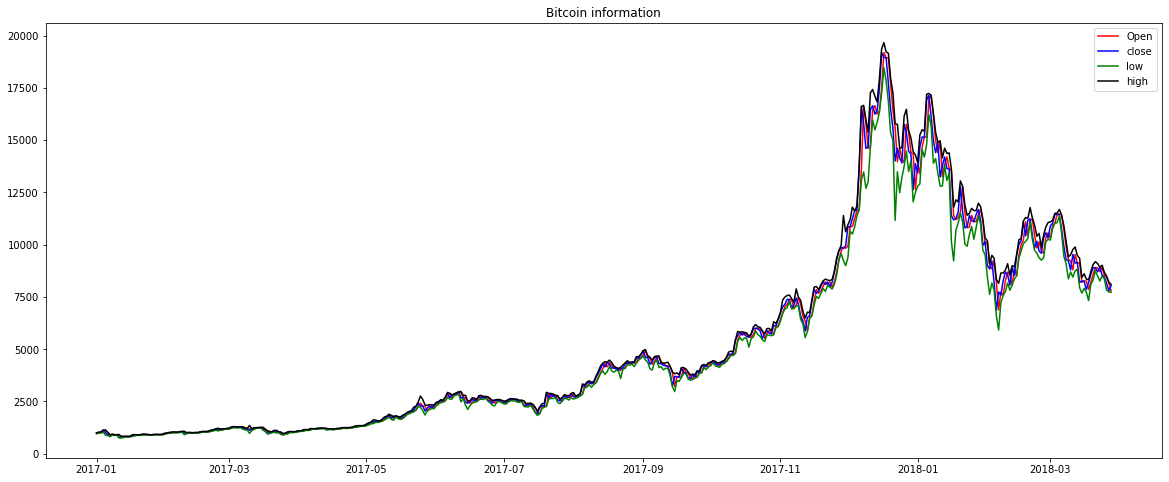

In [386]:
o = plt.plot(Open, color = 'red', label = 'Open')
c = plt.plot(close, color = 'blue', label = 'close')
l = plt.plot(low, color = 'green', label = 'low')
h = plt.plot(high, color = 'black', label = 'high')
plt.legend(loc = 'best')
plt.title('Bitcoin information')

In [387]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(close):
    close_rolling_mean = close.rolling(window =31, center = False).mean()
    close_rolling_std = close.rolling(window =31, center = False).std()
    
    
    plt.plot(close, label = 'original', color ='black')
    plt.plot(close_rolling_mean, color ='blue', label = 'mean')
    plt.plot(close_rolling_std, color ='red',label = 'Std')
    plt.legend(loc ='best')
    plt.title('Close price')
    
    
    print('Close prices')
    close_dftest = adfuller(close['Close'],autolag='AIC')
    close_dfoutput = pd.Series(close_dftest[0:4], index = ['test stastics','Pvalue','lags used','number of observations used'])
    for key , value in close_dftest[4].items():
        close_dfoutput['Critical value (%s)'%key] = value
    print(close_dfoutput)
    


Close prices
test stastics                    3.385005
Pvalue                           1.000000
lags used                       11.000000
number of observations used    338.000000
Critical value (1%)             -3.449846
Critical value (5%)             -2.870129
Critical value (10%)            -2.571346
dtype: float64


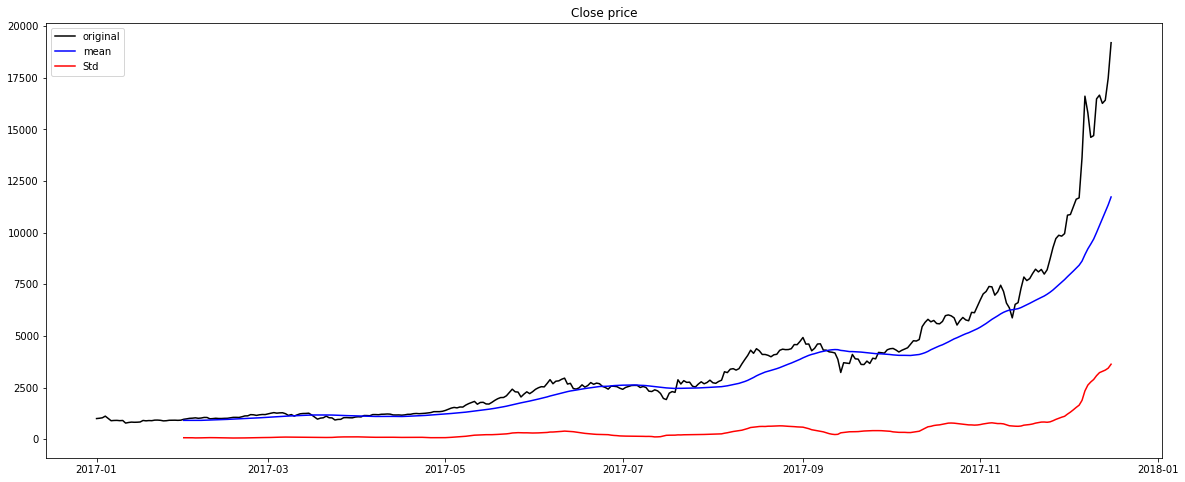

In [361]:
test_stationarity(close)

In [388]:
indexed_close_data_log = np.log(close)
plt.plot(indexed_close_data_log, color = 'black')

Close prices
test stastics                   -1.032467
Pvalue                           0.741239
lags used                        0.000000
number of observations used    451.000000
Critical value (1%)             -3.444933
Critical value (5%)             -2.867970
Critical value (10%)            -2.570195
dtype: float64


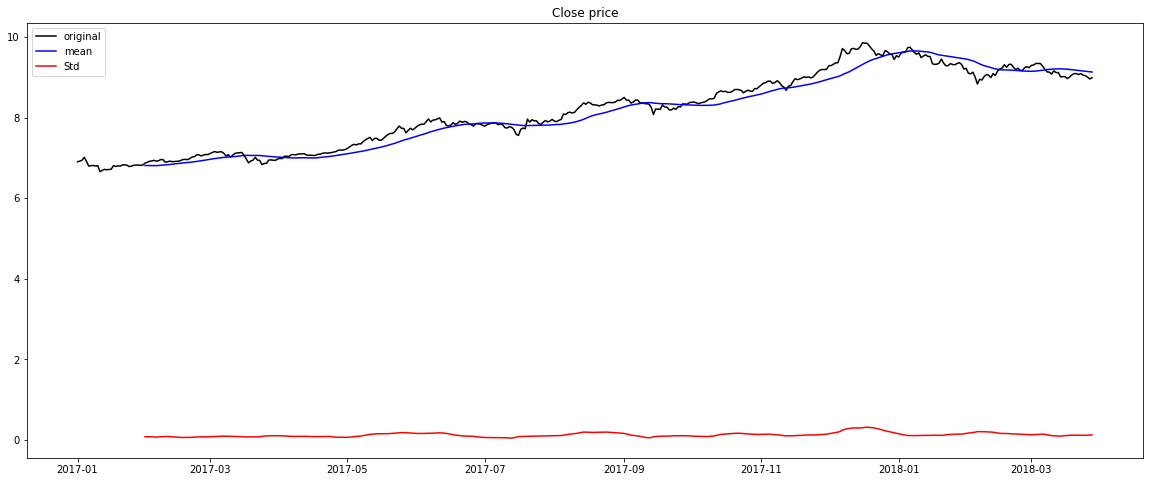

In [389]:
test_stationarity(indexed_close_data_log)

Close prices
test stastics                   -2.885809
Pvalue                           0.047023
lags used                        0.000000
number of observations used    421.000000
Critical value (1%)             -3.445979
Critical value (5%)             -2.868430
Critical value (10%)            -2.570440
dtype: float64


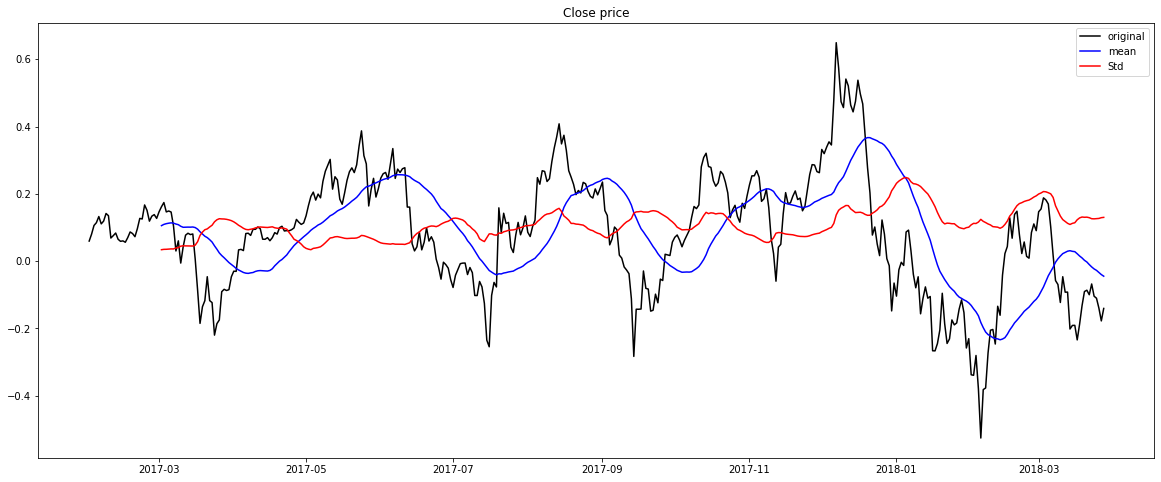

In [390]:
log_data = indexed_close_data_log - indexed_close_data_log.rolling(window =31).mean()
log_data.dropna(inplace =True)
test_stationarity(log_data)

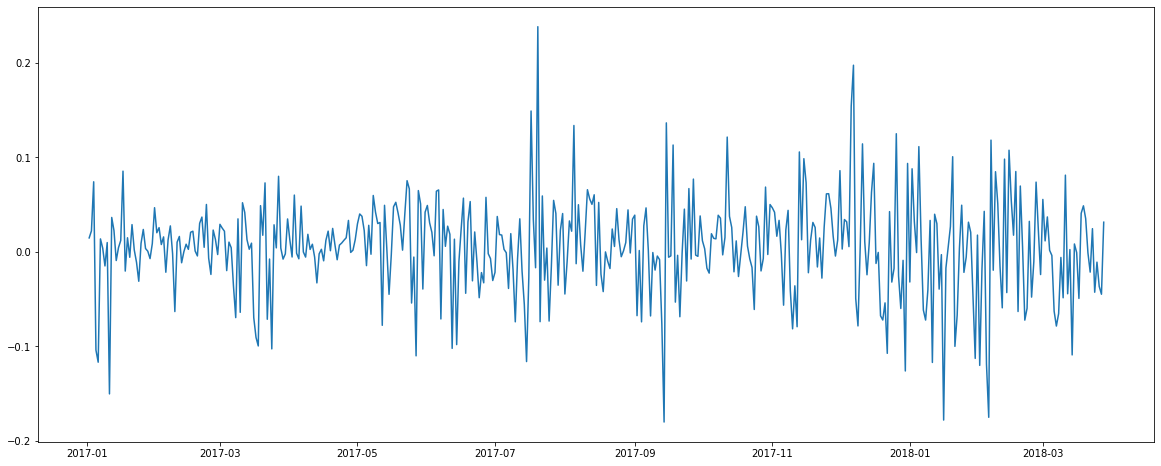

In [391]:
shifted_log_data = indexed_close_data_log - indexed_close_data_log.shift()
plt.plot(shifted_log_data)

Close prices
test stastics                  -21.072460
Pvalue                           0.000000
lags used                        0.000000
number of observations used    450.000000
Critical value (1%)             -3.444966
Critical value (5%)             -2.867984
Critical value (10%)            -2.570203
dtype: float64


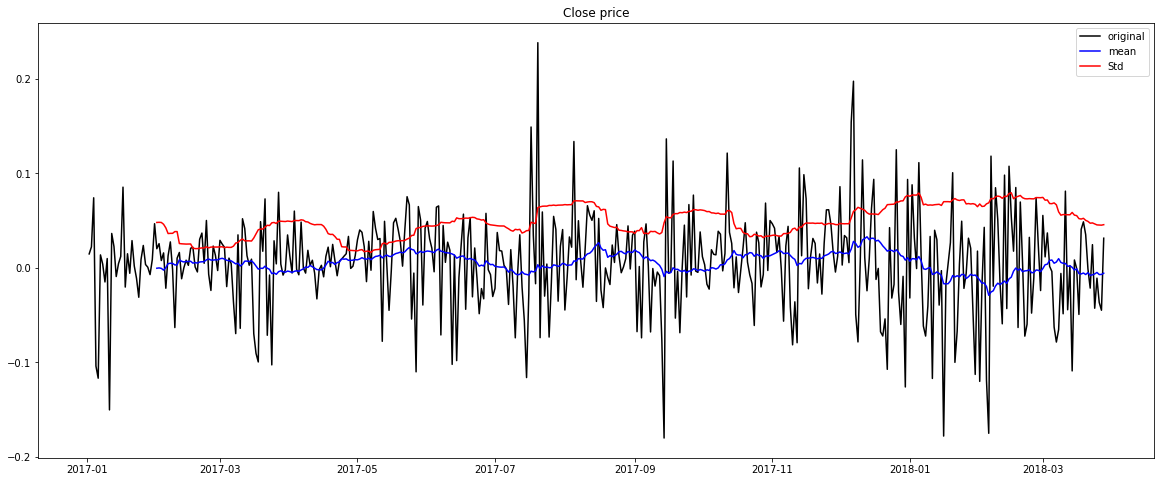

In [392]:
shifted_log_data.dropna(inplace = True)
test_stationarity(shifted_log_data)

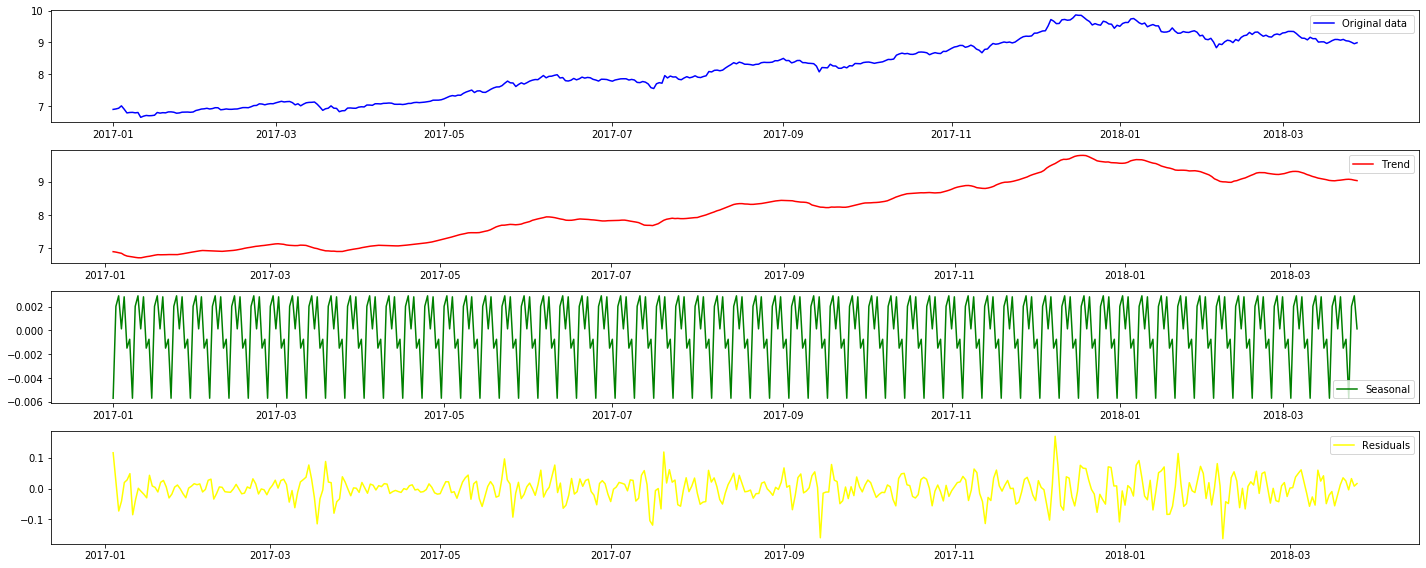

In [393]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(indexed_close_data_log)

trend = decomposition.trend
season = decomposition.seasonal
residuals = decomposition.resid

plt.subplot(411)
plt.plot(indexed_close_data_log, color = 'blue', label = 'Original data ')
plt.legend(loc = 'best')

plt.subplot(412)
plt.plot(trend, color = 'red', label = 'Trend')
plt.legend(loc = 'best')

plt.subplot(413)
plt.plot(season, color = 'green', label = 'Seasonal')
plt.legend(loc = 'best')

plt.subplot(414)
plt.plot(residuals, color = 'yellow', label = 'Residuals')
plt.legend(loc = 'best')

plt.tight_layout()


C:\Users\asus\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


Text(0.5, 1.0, 'PACF graph')

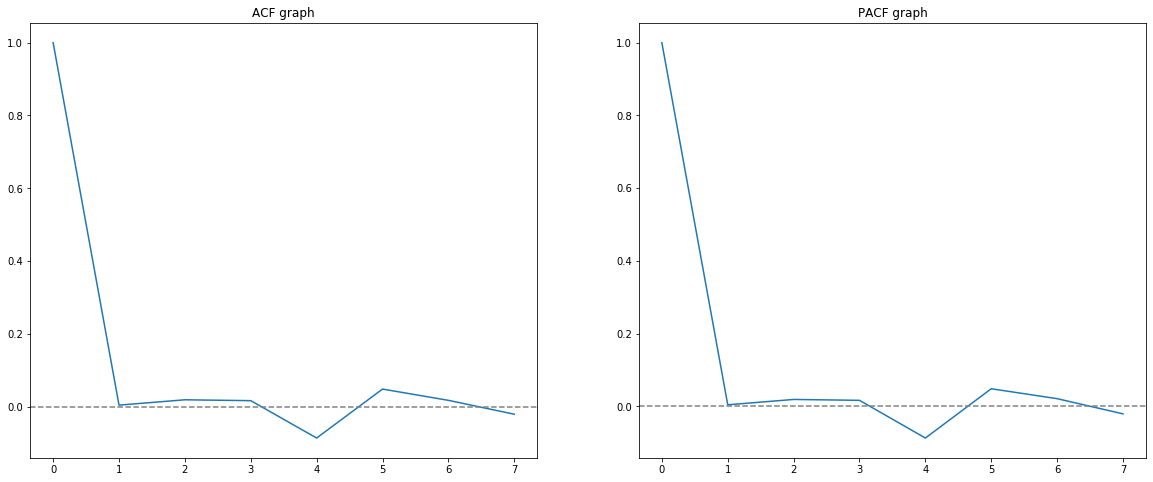

In [414]:
from statsmodels.tsa.stattools import acf, pacf
lagacf = acf(shifted_log_data,nlags = 7)
lagpacf = pacf(shifted_log_data, nlags =7, method = 'ols')

plt.subplot(121)
plt.plot(lagacf)
plt.axhline(y =0 , linestyle = '--', color = 'gray')
plt.title('ACF graph')

plt.subplot(122)
plt.plot(lagpacf)
plt.axhline(y =0 , linestyle = '--', color = 'gray')
plt.title('PACF graph')



In [415]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(indexed_close_data_log, order = (3,1,3))
result_AR = model.fit(disp =-1)
plt.plot(shifted_log_data)
plt.plot(result_AR.fittedvalues, color = 'red')
plt.title('RSS %.4f'% sum((result_AR.fittedvalues-shifted_log_data['Close'])**2))

C:\Users\asus\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS 1.1930')

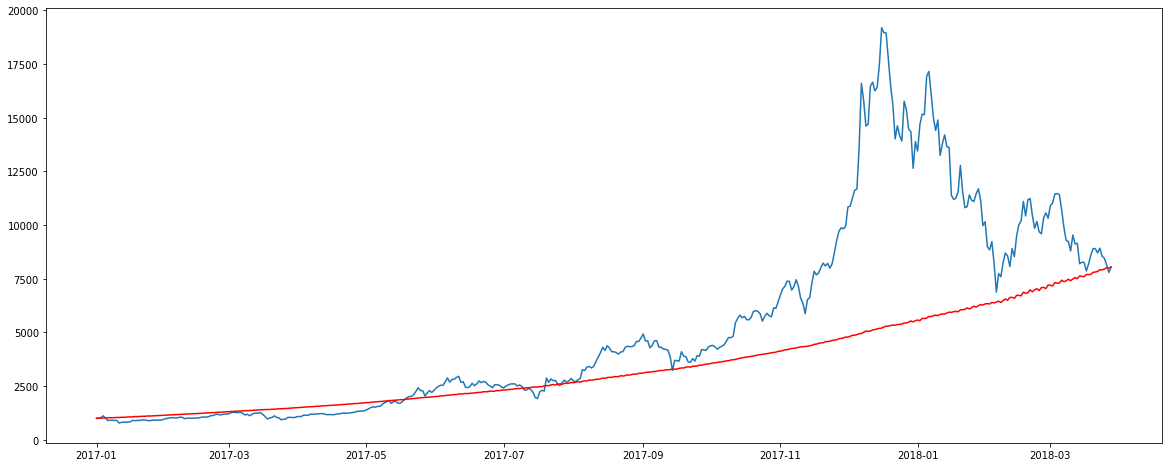

In [435]:
prediction_arima_diff = pd.Series(result_AR.fittedvalues, copy =True)
prediction_arima_diff_cumsum = prediction_arima_diff.cumsum()
prediction_ARIMA_log = pd.Series(indexed_close_data_log['Close'][0], index = indexed_close_data_log.index)
prediction_ARIMA_log = prediction_ARIMA_log.add(prediction_arima_diff_cumsum, fill_value =0)
prediction_ARIMA = np.exp(prediction_ARIMA_log)
plt.plot(close)
plt.plot(prediction_ARIMA, color = 'red')

In [437]:
result_AR.plot_predict(1,700)

In [439]:
result_AR.forecast(steps =10)

(array([8.99665032, 8.99670401, 9.00790333, 9.00900252, 9.01167467,
        9.02202344, 9.02156035, 9.02692379, 9.03548943, 9.03463292]),
 array([0.0514198 , 0.07312022, 0.09030187, 0.10512058, 0.11735413,
        0.12894003, 0.13958693, 0.14903552, 0.1584107 , 0.16707164]),
 array([[8.89586936, 9.09743128],
        [8.85339102, 9.14001699],
        [8.83091491, 9.18489175],
        [8.80296996, 9.21503508],
        [8.7816648 , 9.24168453],
        [8.76930562, 9.27474126],
        [8.747975  , 9.29514571],
        [8.73481954, 9.31902803],
        [8.72501017, 9.34596869],
        [8.70717851, 9.36208732]]))

# train and test data


In [418]:
log_closed_data = np.log(close)
log_closed_data

Close
Timestamp           
2017-01-01  6.905503
2017-01-02  6.920217
2017-01-03  6.942389
2017-01-04  7.016538
2017-01-05  6.912484
...              ...
2018-03-24  9.053336
2018-03-25  9.042383
2018-03-26  9.005731
2018-03-27  8.960814
2018-03-28  8.992167

[452 rows x 1 columns]

In [427]:
train  = log_closed_data[0:351]
test = log_closed_data[351:452]

In [445]:
A_model = ARIMA(train, order = (3,1,3))
f_model = A_model.fit(disp = -1)

result = f_model.forecast(451)

In [446]:
result

(array([ 9.84948966,  9.85548413,  9.87108393,  9.88507093,  9.88802414,
         9.8891699 ,  9.89974983,  9.91660426,  9.92567351,  9.92631345,
         9.93063109,  9.94555449,  9.9601217 ,  9.96479008,  9.96521062,
         9.97460744,  9.99093112, 10.00175958, 10.0028268 , 10.00633232,
        10.01975202, 10.03530401, 10.04109767, 10.04171674, 10.0493348 ,
        10.06550332, 10.07731868, 10.07963669, 10.08193523, 10.09434654,
        10.11001451, 10.11754421, 10.11803662, 10.12455441, 10.1397552 ,
        10.15295351, 10.15611201, 10.1580095 , 10.16878645, 10.18485951,
        10.19353982, 10.19469895, 10.1997106 , 10.21428   , 10.22812492,
        10.23276277, 10.23399255, 10.24363056, 10.25934327, 10.26959614,
        10.27114752, 10.27531463, 10.28860521, 10.30335337, 10.30906008,
        10.31035086, 10.31840808, 10.33398576, 10.34522767, 10.34782123,
        10.35088626, 10.36323064, 10.37819848, 10.38543717, 10.38659986,
        10.39358041, 10.408378  , 10.42087644, 10.4